### Case Study: High-Dimensional Product Function  
To validate the proposed RS-HDMR method for estimating Sobol indices and Shapley effects, we apply it to the product function studied by Owen [1], a benchmark designed to stress-test sensitivity estimators in high-dimensional settings. 


1. **Mathematical Product Function**:  
   The benchmark function is defined as:  
   $$f(\mathbf{x}) = \prod_{j=1}^{d} \left( \mu_j + \tau_j g_j(x_j) \right)$$  
   Where:  
   $$g_j(x_j) = \sqrt{12}(x_j - \tfrac{1}{2}) \quad \text{(zero mean, unit variance)}$$  
   $$\mu_j \equiv 1, \quad \tau_j = \tfrac{1}{4}(4,4,2,2,1,1)$$

2. **Variance Structure**:  
   Analytical Sobol indices for subset $u$:  
   $$\sigma_u^2 = \prod_{j \in u} \tau_j^2 \prod_{j \notin u} \mu_j^2$$  
   Total variance decomposition:  
   $$\sum_{u \subseteq \{1,...,d\}} \sigma_u^2 = \prod_{j=1}^d (1 + \tau_j^2) - 1$$

3. **Key Properties**:  
   - Hierarchical sensitivity: $\tau_j$ values create importance ordering $x_1 \approx x_2 > x_3 \approx x_4 > x_5 \approx x_6$  
   - Interaction dominance: Only $\sim$ 83% variance from 1st/2nd order terms  
   - Normalized configuration: $\sum_{j=1}^6 \tau_j^2 = 1.25$ controls total variance magnitude

---
[1] Owen, Art B. 2013. ‘Better Estimation of Small Sobol’ Sensitivity Indices’. ACM Transactions on Modeling and Computer Simulation 23 (2): 1–17. https://doi.org/10.1145/2457459.2457460.

In [1]:
# Import dependencies
import pandas as pd
import numpy as np

import math

from scipy.spatial import distance 
from shapleyx import rshdmr

from scipy.stats import qmc 

import matplotlib.pyplot as plt

from itertools import combinations

from importlib.metadata import version
print(f"Running on ShapleyX v{version('shapleyx')}")



Running on ShapleyX v0.2


1. **Mathematical Product Function**:  
   The benchmark function is defined as:  
   $$f(\mathbf{x}) = \prod_{j=1}^{d} \left( \mu_j + \tau_j g_j(x_j) \right)$$  
   Where:  
   $$g_j(x_j) = \sqrt{12}(x_j - \tfrac{1}{2}) \quad \text{(zero mean, unit variance)}$$  
   $$\mu_j \equiv 1, \quad \tau_j = \tfrac{1}{4}(4,4,2,2,1,1)$$

2. **Variance Structure**:  
   Analytical Sobol indices for subset $u$:  
   $$\sigma_u^2 = \prod_{j \in u} \tau_j^2 \prod_{j \notin u} \mu_j^2$$  
   Total variance decomposition:  
   $$\sum_{u \subseteq \{1,...,d\}} \sigma_u^2 = \prod_{j=1}^d (1 + \tau_j^2) - 1$$

3. **Key Properties**:  
   - Hierarchical sensitivity: $\tau_j$ values create importance ordering $x_1 \approx x_2 > x_3 \approx x_4 > x_5 \approx x_6$  
   - Interaction dominance: Only $\sim$83% variance from 1st/2nd order terms  
   - Normalized configuration: $\sum_{j=1}^6 \tau_j^2 = 1.25$ controls total variance magnitude

##### Helper functions for building quasi-random sample from the Product Function
Using Sobol sequence sampling with LMS+shift scrambling

In [2]:
def get_column_labels(num_columns):
    return [f'X{i+1}' for i in range(num_columns)]

def owen(m, d, tau_values, mu_values):
    num_dimensions = d
    tau_values = [1, 1, 0.5, 0.5, 0.25, 0.25]
    mu_values = [1, 1, 1, 1, 1, 1]
    
    num_samples = 2**m
    sampler = qmc.Sobol(d, scramble=True, seed=123)
    samples = sampler.random_base2(m)
    
    # Initialize Y with ones and compute product
    Y = np.ones(num_samples)
    for dim in range(num_dimensions):
        g = np.sqrt(12) * (samples[:, dim] - 0.5)
        Y *= (mu_values[dim] + tau_values[dim] * g)
    
    data = pd.DataFrame(samples, columns=get_column_labels(num_dimensions))
    data['Y'] = Y
    return data


##### Using the helper functions, build a dataframe of samples of a designate size
The number of samples in the controlled by m where the number of samples is $2^m$. \
The number of variables, $d$ has to be defined as well as the value of $\tau_j$ and $\mu_j$

In [3]:
# m = 8 -> 256 samples
# m = 9 -> 512 samples
# m = 10 -> 1024 samples
# m = 11 -> 2048 samples 
# m = 12 -> 4096 samples
# m = 13 -> 8192 samples

m=8
d = 6
tau = [1, 1, 0.5, 0.5, 0.25, 0.25]
mu = [1, 1, 1, 1, 1, 1]


dataframe = owen(m, d, tau, mu)
print(len(dataframe), 'samples generated')

256 samples generated


Found a DataFrame

Transforming data to unit hypercube

Feature: X1, Min Value: 0.0036, Max Value: 0.9980
Feature: X2, Min Value: 0.0037, Max Value: 0.9969
Feature: X3, Min Value: 0.0020, Max Value: 0.9983
Feature: X4, Min Value: 0.0013, Max Value: 0.9995
Feature: X5, Min Value: 0.0030, Max Value: 0.9968
Feature: X6, Min Value: 0.0031, Max Value: 0.9999

Building basis functions

Basis functions of 1 order : 48
Basis functions of 2 order : 540
Basis functions of 3 order : 1280
Basis functions of 4 order : 3840
Total basis functions in basis set : 5708
Total number of features in basis set is 5708

Running regression analysis

running ARD
Iteration: 0     Mean CV Score: 0.2141, Percentage Change: inf%
Iteration: 1     Mean CV Score: 0.3470, Percentage Change: 62.09%
Iteration: 2     Mean CV Score: 0.3923, Percentage Change: 13.05%
Iteration: 3     Mean CV Score: 0.4339, Percentage Change: 10.61%
Iteration: 4     Mean CV Score: 0.4671, Percentage Change: 7.65%
Iteration: 5     Mean CV Sc

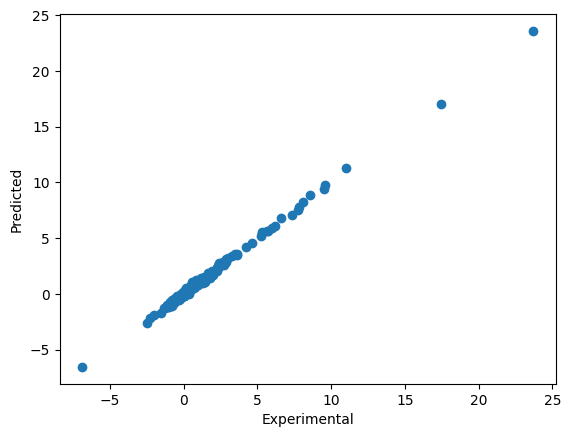


Running bootstrap resampling 1000 samples for 95.0% CI

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 

Completed bootstrap resampling


                  Completed all analysis
                 ------------------------

Your ability to learn faster than your competition is your
only sustainable competitive advantage.  Arie de Gues



In [4]:
model = rshdmr(dataframe,
               polys = [8, 6, 4, 4], 
               n_iter = 100,
#               verbose=True,
               method = 'ard_cv',
               cv_tol=0.005
              )
               
sob, shap, total = model.run_all() 

In [5]:
def powerset(input_list):
    """Return all non-empty members of the powerset."""
    all_combinations = []
    for r in range(1, len(input_list) + 1):  # Start at 1 instead of 0
        all_combinations.extend(
            [list(comb) for comb in combinations(input_list, r)]
        )
    return all_combinations

def sigma_u_squared(u, tau, mu):
    product_tau = math.prod(tau[j]**2 for j in u)
    n = len(tau)
    product_mu = math.prod(mu[j]**2 for j in range(n) if j not in u)
    return product_tau * product_mu


In [6]:
shapleys = [0] * 6
myset = list(range(6)) 
total_var = 0

my_powerset = powerset(myset)
for subset in my_powerset:
    sig_squared = sigma_u_squared(subset, tau, mu)
#    print(f"Subset: {subset}, Sigma_u^2: {sig_squared}")
    for i in subset:
        shapleys[i] += sig_squared / len(subset)
        total_var += sig_squared / len(subset)

shap['analytical'] = np.array(shapleys)/total_var

In [7]:
sigma_u_squared([5,1], tau, mu)/total_var

0.010320915981293364

In [8]:
df = pd.DataFrame()
df['Category'] = shap['label']
df['Value1'] = shap['scaled effect']
df['Value2'] = shap['analytical']
df['Lower'] = shap['lower']
df['Upper'] = shap['upper']

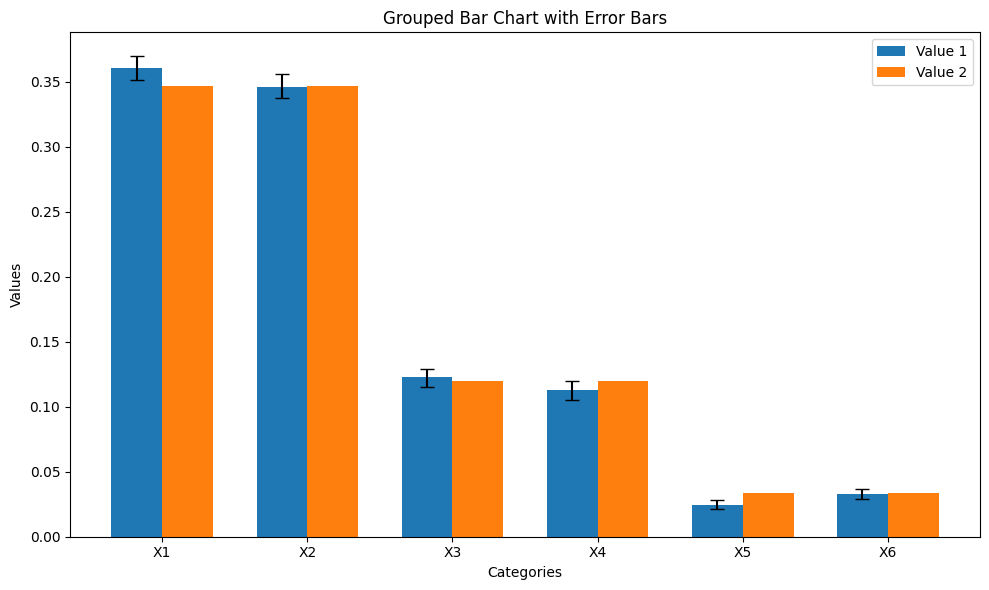

In [9]:


# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Set the width of each bar
bar_width = 0.35

# Positions of the bars on the x-axis
x = np.arange(len(df['Category']))

# Plot the bars
bars1 = ax.bar(x - bar_width/2, df['Value1'], bar_width, 
               label='Value 1', yerr=[df['Value1']-df['Lower'], df['Upper']-df['Value1']],
               capsize=5)

bars2 = ax.bar(x + bar_width/2, df['Value2'], bar_width, 
               label='Value 2')

# Add labels, title, and legend
ax.set_xlabel('Categories')
ax.set_ylabel('Values')
ax.set_title('Grouped Bar Chart with Error Bars')
ax.set_xticks(x)
ax.set_xticklabels(df['Category'])
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [10]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Apr 08 2025

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.30.0

scipy     : 1.14.1
__main__  : <function version at 0x000001CDDB15CA40>
pandas    : 2.2.3
matplotlib: 3.7.3
numpy     : 1.26.4
shapleyx  : 0.2

Watermark: 2.5.0



In [11]:
model.get_interactions(2)

,interaction,shapley_value
0,"{X1, X2}",0.229311
1,"{X1, X3}",0.079148
2,"{X1, X4}",0.077901
3,"{X1, X5}",0.016167
4,"{X1, X6}",0.022792
5,"{X3, X2}",0.072165
6,"{X4, X2}",0.068971
7,"{X5, X2}",0.014839
8,"{X6, X2}",0.021297
9,"{X4, X3}",0.022111


In [13]:
from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s) + 1))

def calculate_Sh_s(A, s, S_func):
    """
    Calculate Sh_s according to the given equation.
    
    Parameters:
    A (set): The universal set.
    s (set): The subset of A for which we are calculating Sh_s.
    S_func (function): A function that takes two arguments, the subset s and a subset u, and returns the value S_{s,u}.
    
    Returns:
    float: The computed value of Sh_s.
    """
    A = set(A)
    s = set(s)
    assert s.issubset(A), "s must be a subset of A"
    
    A_minus_s = A - s
    total = 0.0
    
    for subset in powerset(A_minus_s):
        u = set(subset).union(s)
        S_value = S_func(s, u)
        term = S_value / (len(u) + 1)
        total += term
    
    return total

In [14]:
A = {0, 1, 2, 3, 4, 5 }
s = {1,2}
calculate_Sh_s(A, s, S_func)


NameError: name 'S_func' is not defined

In [87]:
shap

,label,effect,scaled effect,lower,upper,analytical
0,X1,0.359621,0.360610,0.351111,0.369091,0.346867
1,X2,0.345110,0.346059,0.336418,0.355696,0.346867
2,X3,0.122165,0.122501,0.115856,0.130001,0.119793
3,X4,0.112762,0.113072,0.105070,0.120036,0.119793
4,X5,0.024560,0.024627,0.021288,0.027936,0.033339
5,X6,0.033040,0.033131,0.029232,0.036956,0.033339


In [93]:
shapleys

[2.1005126953125006,
 2.1005126953125006,
 0.7254272460937502,
 0.7254272460937502,
 0.2018920898437501,
 0.2018920898437501]

In [98]:
sob

,derived_labels,index,lower,upper
0,X1,0.172359,0.163677,0.180921
1,X1_X2,0.172734,0.164157,0.182456
2,X1_X2_X3,0.038213,0.032654,0.043846
3,X1_X2_X3_X4,0.011818,0.008094,0.016083
4,X1_X2_X3_X5,0.004069,0.002197,0.005922
5,X1_X2_X3_X6,0.003422,0.001773,0.005269
6,X1_X2_X4,0.039837,0.034538,0.045549
7,X1_X2_X4_X6,0.002701,0.001441,0.004739
8,X1_X2_X5,0.008909,0.006830,0.011397
9,X1_X2_X5_X6,0.000589,0.000137,0.001541


In [ ]:
s = [1]
for i in my_powerset:
    i = set(i)
    s = set(s)
    if s.issubset(i):
        print(i)
    

{1}
{0, 1}
{1, 2}
{1, 3}
{1, 4}
{1, 5}
{0, 1, 2}
{0, 1, 3}
{0, 1, 4}
{0, 1, 5}
{1, 2, 3}
{1, 2, 4}
{1, 2, 5}
{1, 3, 4}
{1, 3, 5}
{1, 4, 5}
{0, 1, 2, 3}
{0, 1, 2, 4}
{0, 1, 2, 5}
{0, 1, 3, 4}
{0, 1, 3, 5}
{0, 1, 4, 5}
{1, 2, 3, 4}
{1, 2, 3, 5}
{1, 2, 4, 5}
{1, 3, 4, 5}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 5}
{0, 1, 2, 4, 5}
{0, 1, 3, 4, 5}
{1, 2, 3, 4, 5}
{0, 1, 2, 3, 4, 5}


In [59]:
sob

,derived_labels,index,lower,upper
0,X1,0.172359,0.164962,0.180075
1,X1_X2,0.172734,0.163470,0.181411
2,X1_X2_X3,0.038213,0.032813,0.044151
3,X1_X2_X3_X4,0.011818,0.007904,0.015887
4,X1_X2_X3_X5,0.004069,0.002371,0.005861
5,X1_X2_X3_X6,0.003422,0.001846,0.005364
6,X1_X2_X4,0.039837,0.034413,0.045177
7,X1_X2_X4_X6,0.002701,0.001301,0.004666
8,X1_X2_X5,0.008909,0.006666,0.011685
9,X1_X2_X5_X6,0.000589,0.000132,0.001557


In [142]:
interact = ['X1']
sum = 0
set = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6']
for interact in combinations(set, 1):
    sum = 0
    for i, j in sob.iterrows():
        print(j['derived_labels'].split('_'))

['X1']
['X1', 'X2']
['X1', 'X2', 'X3']
['X1', 'X2', 'X3', 'X4']
['X1', 'X2', 'X3', 'X5']
['X1', 'X2', 'X3', 'X6']
['X1', 'X2', 'X4']
['X1', 'X2', 'X4', 'X6']
['X1', 'X2', 'X5']
['X1', 'X2', 'X5', 'X6']
['X1', 'X2', 'X6']
['X1', 'X3']
['X1', 'X3', 'X4']
['X1', 'X3', 'X5']
['X1', 'X3', 'X5', 'X6']
['X1', 'X3', 'X6']
['X1', 'X4']
['X1', 'X4', 'X5']
['X1', 'X4', 'X6']
['X1', 'X5']
['X1', 'X6']
['X2']
['X2', 'X3']
['X2', 'X3', 'X4']
['X2', 'X3', 'X4', 'X6']
['X2', 'X3', 'X5']
['X2', 'X3', 'X5', 'X6']
['X2', 'X3', 'X6']
['X2', 'X4']
['X2', 'X4', 'X5']
['X2', 'X4', 'X5', 'X6']
['X2', 'X4', 'X6']
['X2', 'X5']
['X2', 'X6']
['X3']
['X3', 'X4']
['X3', 'X4', 'X5', 'X6']
['X3', 'X5']
['X3', 'X6']
['X4']
['X4', 'X5']
['X4', 'X6']
['X5']
['X5', 'X6']
['X6']
['X1']
['X1', 'X2']
['X1', 'X2', 'X3']
['X1', 'X2', 'X3', 'X4']
['X1', 'X2', 'X3', 'X5']
['X1', 'X2', 'X3', 'X6']
['X1', 'X2', 'X4']
['X1', 'X2', 'X4', 'X6']
['X1', 'X2', 'X5']
['X1', 'X2', 'X5', 'X6']
['X1', 'X2', 'X6']
['X1', 'X3']
['X1', 'X3', 

In [18]:
if {'upper', 'lowerx'}.issubset(sob.columns):
    errors = True
    sob['error'] = (sob['upper']-sob['lower'])/2


In [35]:
p_set = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6']
label_list  = []
shap_list = []
error_list = []
total = 0
for interact in combinations(p_set, 4):
    sum = 0
    error = 0
    interact = set(interact)
    for i, j in sob.iterrows():
        label = j['derived_labels'].split('_')
        label = set(list(label))
        if interact.issubset(label):
            n = len(label) - len(interact) + 1
            sum += j['index'] / n
            error += (j['sd'] / n)**2
    total += sum
    prop_error = np.sqrt(error)
    error_list.append(prop_error)
    label_list.append(interact)
    shap_list.append(sum)

    upper = sum + 1.96*prop_error
    lower = sum - 1.96*prop_error
    print(interact, sum,lower, upper)
print(total)

{'X2', 'X3', 'X4', 'X1'} 0.011817767761046849 0.008194201620787264 0.015441333901306434
{'X2', 'X3', 'X5', 'X1'} 0.004068505514200058 0.0023126464878557114 0.005824364540544404
{'X2', 'X3', 'X6', 'X1'} 0.003421844660828892 0.001738208686397869 0.005105480635259915
{'X2', 'X5', 'X4', 'X1'} 0 0.0 0.0
{'X2', 'X6', 'X4', 'X1'} 0.002701273961250442 0.0011609412670389875 0.004241606655461896
{'X2', 'X6', 'X5', 'X1'} 0.0005888950276498366 -9.764098477462368e-05 0.0012754310400742968
{'X4', 'X3', 'X5', 'X1'} 0 0.0 0.0
{'X4', 'X3', 'X6', 'X1'} 0 0.0 0.0
{'X3', 'X6', 'X5', 'X1'} 4.11803698863807e-05 -0.00012725555155721939 0.0002096162913299808
{'X4', 'X6', 'X5', 'X1'} 0 0.0 0.0
{'X2', 'X3', 'X5', 'X4'} 0 0.0 0.0
{'X2', 'X3', 'X6', 'X4'} 0.00046886186645325885 3.985424311411887e-05 0.0008978694897923988
{'X2', 'X3', 'X6', 'X5'} 0.00027560900990240643 -0.00014468297188116624 0.0006959009916859792
{'X2', 'X5', 'X4', 'X6'} 0.00030929111739420975 -0.0001912243280108995 0.000809806562799319
{'X4', 'X

{'X1'} 0.3596212696790074 0.34935464573702185 0.369887893620993
{'X2'} 0.3451104633890257 0.3343807735885075 0.3558401531895439
{'X3'} 0.12216494656646369 0.11595653334030527 0.12837335979262213
{'X4'} 0.1127621584336162 0.10667274442514652 0.11885157244208588
{'X5'} 0.024559576704523377 0.021865633182961308 0.027253520226085445
{'X6'} 0.03304006875173186 0.030057890204689738 0.03602224729877399
0.9972584835243682

In [22]:
if {'upper', 'lower'}.issubset(sob.columns):
    errors = True
    sob['error'] = (sob['upper']-sob['lower'])/2

In [23]:
sob

,derived_labels,index,lower,upper,error
0,X1,0.172359,0.164295,0.180438,0.008071
1,X1_X2,0.172734,0.163889,0.181515,0.008813
2,X1_X2_X3,0.038213,0.032643,0.044068,0.005713
3,X1_X2_X3_X4,0.011818,0.008153,0.015704,0.003775
4,X1_X2_X3_X5,0.004069,0.002232,0.005966,0.001867
5,X1_X2_X3_X6,0.003422,0.001850,0.005253,0.001701
6,X1_X2_X4,0.039837,0.034472,0.044878,0.005203
7,X1_X2_X4_X6,0.002701,0.001439,0.004541,0.001551
8,X1_X2_X5,0.008909,0.006764,0.011306,0.002271
9,X1_X2_X5_X6,0.000589,0.000140,0.001536,0.000698


In [75]:
model.X.columns


Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6'], dtype='object')

In [67]:
def calculate_owen_interactions(p_set, sob_df, interaction_size=2):
    """
    Calculate Owen product function interactions with error propagation.
    
    Args:
        p_set: List of variable names (e.g., ['X1', 'X2', ..., 'X6'])
        sob_df: DataFrame containing 'derived_labels', 'index', and 'sd' columns
        interaction_size: Size of interactions to calculate (default: 4)
        
    Returns:
        DataFrame with columns: interaction, shapley_value, lower_ci, upper_ci, error
    """
    results = []
    errors = False

    if {'upper', 'lower'}.issubset(sob_df.columns):
        errors = True
        sob_df['error'] = (sob_df['upper']-sob_df['lower'])/2
    
    for interact in combinations(p_set, interaction_size):
        interact = set(interact)
        mask = sob_df['derived_labels'].apply(
            lambda x: interact.issubset(set(x.split('_')))
        )
        
        filtered = sob_df[mask]
        n_values = filtered['derived_labels'].apply(lambda x: len(set(x.split('_'))) - len(interact) + 1)
        
        sum_val = (filtered['index'] / n_values).sum()
        
        results.append({
            'interaction': interact,
            'shapley_value': sum_val,
        })
        
        if errors :
            error = np.sqrt((filtered['error'] / n_values).pow(2).sum())
            results[len(results)-1]['lower_ci'] = sum_val - error
            results[len(results)-1]['upper_ci'] = sum_val + error
    
    return pd.DataFrame(results)

In [70]:
shap

,label,effect,scaled effect,lower,upper,analytical
0,X1,0.359621,0.360610,0.351561,0.369235,0.346867
1,X2,0.345110,0.346059,0.337249,0.355544,0.346867
2,X3,0.122165,0.122501,0.115362,0.129942,0.119793
3,X4,0.112762,0.113072,0.104888,0.119593,0.119793
4,X5,0.024560,0.024627,0.020961,0.028099,0.033339
5,X6,0.033040,0.033131,0.029047,0.036980,0.033339


In [77]:
calculate_owen_interactions(model.X.columns, sob, 2)

,interaction,shapley_value,lower_ci,upper_ci
0,"{X2, X1}",0.229311,0.219213,0.239409
1,"{X3, X1}",0.079148,0.072972,0.085325
2,"{X4, X1}",0.077901,0.071631,0.084170
3,"{X5, X1}",0.016167,0.013783,0.018550
4,"{X6, X1}",0.022792,0.019801,0.025784
5,"{X3, X2}",0.072165,0.066090,0.078241
6,"{X4, X2}",0.068971,0.062699,0.075244
7,"{X5, X2}",0.014839,0.012099,0.017579
8,"{X6, X2}",0.021297,0.018321,0.024274
9,"{X4, X3}",0.022111,0.018805,0.025417


In [63]:
sob2 = sob.copy()
del sob2['lower']
del sob2['upper']

,derived_labels,index,error
0,X1,0.172359,0.007556
1,X1_X2,0.172734,0.008970
2,X1_X2_X3,0.038213,0.005669
3,X1_X2_X3_X4,0.011818,0.003992
4,X1_X2_X3_X5,0.004069,0.001745
5,X1_X2_X3_X6,0.003422,0.001759
6,X1_X2_X4,0.039837,0.005382
7,X1_X2_X4_X6,0.002701,0.001683
8,X1_X2_X5,0.008909,0.002509
9,X1_X2_X5_X6,0.000589,0.000713
